In [23]:
# Importação de bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, explained_variance_score, median_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from xgboost import XGBRegressor

In [24]:
# Carregar dados
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
df = pd.read_csv('/content/drive/MyDrive/07_per_shared/projCDat_25_1/datasets/cooked/_all/all_merged.csv')

# Visualizar as primeiras linhas
display(df.head())

# Verificar estatísticas básicas
display(df.describe())

,_ano,_estado,_mes,car_c02_emitido,cli_pressao_atm_med,cli_temp_ar_med,cli_temp_orvalho_med,cli_umid_rel_med,cli_umid_rel_min_max,cli_umid_rel_min_med,cli_umid_rel_min_min,cli_veloc_vento_max,cli_veloc_vento_med,que_area_queimada,que_focos_qtd
0,2008,AC,7,2.627698e+07,986.843612,28.142731,18.914978,59.555066,95.0,54.432558,29.0,5.1,2.152915,4957.0,165.0
1,2008,AC,9,2.627698e+07,991.705941,24.446194,19.467987,75.811881,97.0,72.496700,25.0,1.0,0.210504,46073.0,2947.0
2,2008,AC,10,2.627698e+07,990.328360,25.229298,21.617473,81.870968,96.0,78.720430,29.0,1.0,0.204959,30355.0,856.0
3,2008,AC,11,2.627698e+07,988.610987,25.195410,22.624478,86.905424,96.0,84.048679,42.0,1.0,0.186970,2082.0,63.0
4,2008,AC,12,2.627698e+07,988.692608,24.898790,22.727554,88.529570,96.0,86.116935,53.0,1.0,0.179442,127.0,4.0


,_ano,_mes,car_c02_emitido,cli_pressao_atm_med,cli_temp_ar_med,cli_temp_orvalho_med,cli_umid_rel_med,cli_umid_rel_min_max,cli_umid_rel_min_med,cli_umid_rel_min_min,cli_veloc_vento_max,cli_veloc_vento_med,que_area_queimada,que_focos_qtd
count,1025.000000,1025.000000,1.025000e+03,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1.025000e+03,1025.000000
mean,2014.468293,6.500488,1.075203e+08,993.395296,26.429096,21.282504,75.905264,94.459512,72.934699,38.312195,3.862341,1.245765,1.091449e+05,571.351247
std,5.288477,3.453691,1.339531e+08,17.095487,1.451484,2.739868,11.655088,5.129625,11.923162,12.696814,1.340376,0.668292,2.512339e+05,1203.694989
min,2000.000000,1.000000,3.271708e+06,922.979722,21.979722,7.230854,16.969925,30.000000,14.961620,9.000000,0.600000,0.016348,1.000000e+00,1.000000
25%,2010.000000,4.000000,3.130998e+07,986.197470,25.463194,20.737032,70.405995,94.000000,67.305556,30.000000,3.000000,0.824373,2.954000e+03,3.500000
50%,2014.000000,7.000000,5.666977e+07,997.229524,26.293280,22.111877,79.000000,95.000000,75.870968,39.000000,3.600000,1.155405,1.435600e+04,26.000000
75%,2019.000000,9.000000,1.148093e+08,1004.589771,27.304131,22.931942,83.946019,97.000000,81.094891,47.000000,4.700000,1.479324,8.966600e+04,366.000000
max,2023.000000,12.000000,6.532973e+08,1012.780333,31.763194,25.987448,92.390578,100.000000,91.860119,77.000000,9.600000,4.102525,3.144010e+06,7669.000000


In [26]:
# Remover linhas com valores nulos na variável alvo
df = df.dropna(subset=['que_area_queimada'])

# Separar variáveis e alvo
X = df.drop('que_area_queimada', axis=1)
y = df['que_area_queimada']

# Analisar variável alvo
display(y.describe())

# Definir colunas categóricas e numéricas
categorical_cols = ['_estado', '_mes']
numeric_cols = [col for col in X.columns if col not in categorical_cols and col != 'que_area_queimada']

# Transformações
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

,que_area_queimada
count,1.025000e+03
mean,1.091449e+05
std,2.512339e+05
min,1.000000e+00
25%,2.954000e+03
50%,1.435600e+04
75%,8.966600e+04
max,3.144010e+06


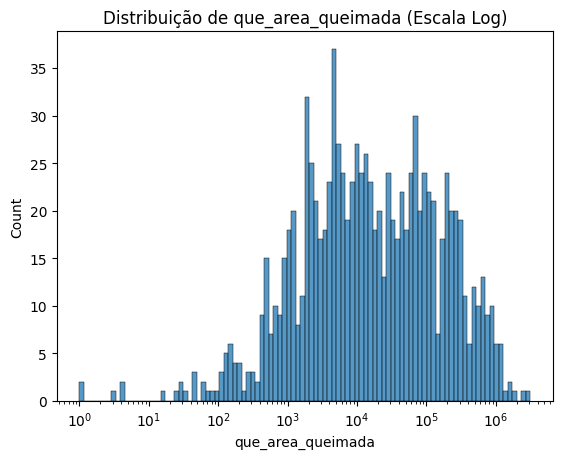

In [27]:
# Avaliar distribuição da variável alvo (em escala logarítmica)
sns.histplot(y, bins=100, log_scale=True)
plt.title('Distribuição de que_area_queimada (Escala Log)')
plt.show()

In [28]:
# Dividir dados
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Pré-processamento
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Criar e treinar o modelo XGBoost
model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    early_stopping_rounds=20,
    eval_metric='rmse'
)

model.fit(
    X_train_processed,
    y_train,
    eval_set=[(X_test_processed, y_test)],
    verbose=False
)

# Previsões
y_pred = model.predict(X_test_processed)

In [29]:
# Avaliação
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
medae = median_absolute_error(y_test, y_pred)
evs = explained_variance_score(y_test, y_pred)

# Exibir resultados
print(f'RMSE: {rmse:.2f}')
print(f'R²: {r2:.4f}')
print(f'MAE: {mae:.2f}')
print(f'MAPE: {mape * 100:.2f}%')
print(f'MedAE: {medae:.2f}')
print(f'Explained Variance Score: {evs:.4f}')
print(f'RMSE: {rmse:.2f}')

RMSE: 162214.46
R²: 0.7016
MAE: 68368.18
MAPE: 2981.83%
MedAE: 13527.62
Explained Variance Score: 0.7018
RMSE: 162214.46


# ANÁLISE GRÁFICA

## Importância das _Features_

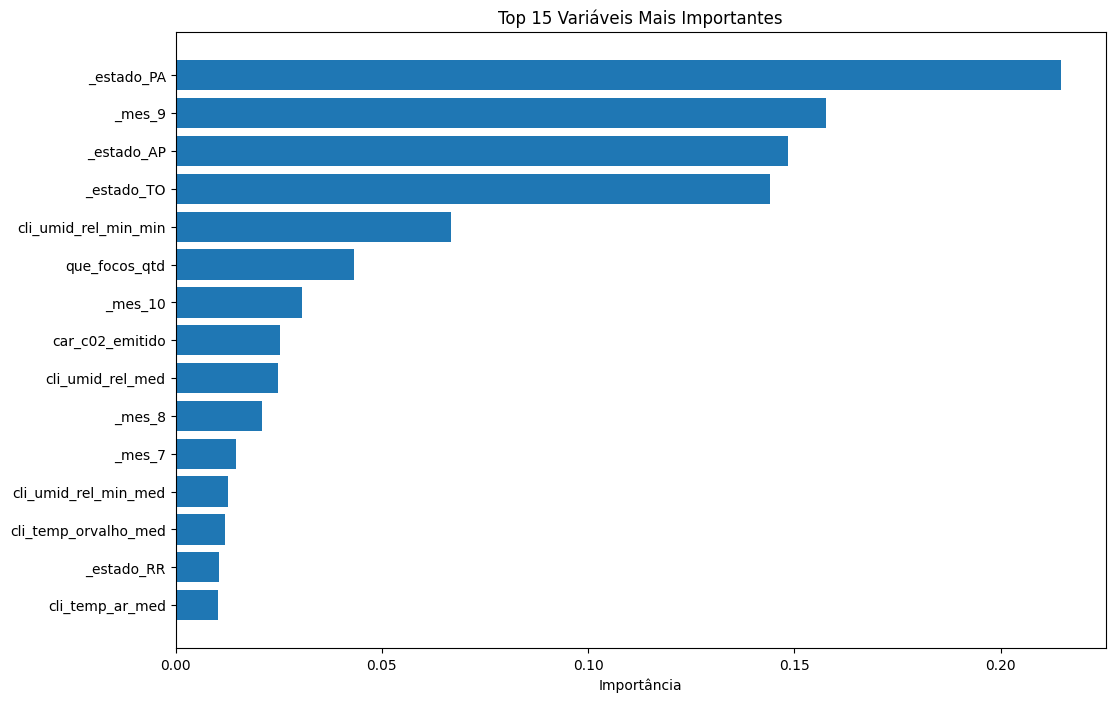

In [30]:
# Feature Importance
feature_names = numeric_cols + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols))
importances = model.feature_importances_
sorted_idx = importances.argsort()[::-1]

# Gráfico de importância
plt.figure(figsize=(12, 8))
plt.barh(np.array(feature_names)[sorted_idx][:15], importances[sorted_idx][:15])
plt.xlabel('Importância')
plt.title('Top 15 Variáveis Mais Importantes')
plt.gca().invert_yaxis()
plt.show()

## Resíduos _vs_ Valores Preditos

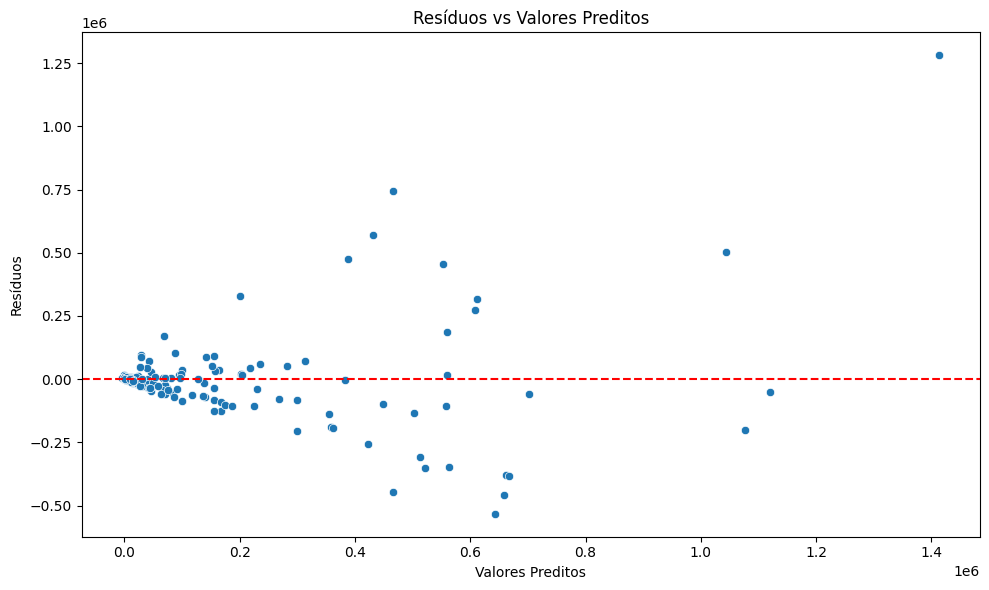

In [31]:
residues = y_test - y_pred

# --- Gráfico de resíduos ---
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residues)
plt.axhline(0, color='red', linestyle='--')
plt.title("Resíduos vs Valores Preditos")
plt.xlabel("Valores Preditos")
plt.ylabel("Resíduos")
plt.tight_layout()
plt.show()

## Histograma de resíduos

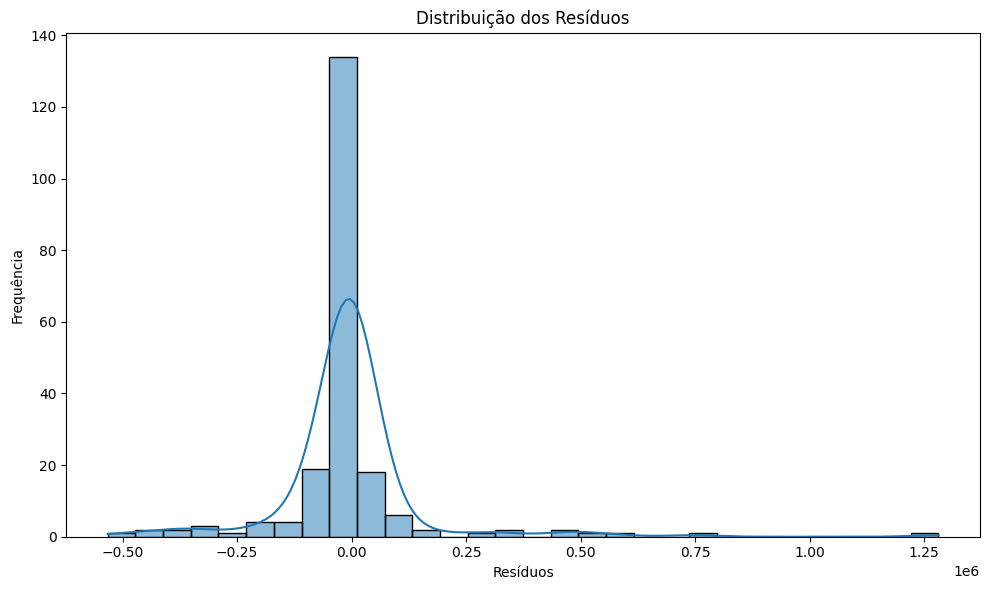

In [32]:
plt.figure(figsize=(10, 6))
sns.histplot(residues, bins=30, kde=True)
plt.title("Distribuição dos Resíduos")
plt.xlabel("Resíduos")
plt.ylabel("Frequência")
plt.tight_layout()
plt.show()